<a href="https://colab.research.google.com/github/Mogarthron/Magazynier/blob/master/DOSTAWY_PIANEK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sqlalchemy import create_engine, text

from datetime import datetime as dt, timedelta
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [ ]:
engine = create_engine("sqlite:///drive/MyDrive/GENERATORY.db", echo=False)
with engine.begin() as conn:
      tab = pd.read_sql(text("SELECT * from baza_PIANKI"), conn)
      zp_tab = pd.read_sql(text("SELECT * from ZAM_PIANKI"), conn)
zp_tab["KOMPLETACJA"] = zp_tab["MODEL"] + " " + zp_tab["NR_KOMPLETACJI"]
zp_tab["nr_SAMOCHODU"].fillna("", inplace=True)
zp_tab = zp_tab[zp_tab.STATUS_KOMPLETACJA !="1"]

tab["vol"] = tab.DLUG*tab.SZER*tab.WYS/1000_000_000
tab["VOL"] = tab.vol*tab.ilosc


In [ ]:
komplety_pianek = pd.read_excel("drive/MyDrive/ZAM_PIANKI.xlsx", sheet_name="Arkusz3")
komplety_pianek['CZY_BRYLA'] = komplety_pianek['CZY_BRYLA'].fillna(1)
komplety_pianek['BRYLA_GEN'] = komplety_pianek['BRYLA_GEN'].fillna("").astype(str).apply(lambda x: x.replace(".", ","))

aktywne_dos = pd.read_excel("drive/MyDrive/ZAM_PIANKI.xlsx", sheet_name="AKTYWNE_DOS")

In [ ]:
def obietosci_samochodow(dostawca, tabela):

  dostawy = tabela[tabela.nr_SAMOCHODU.str.contains(dostawca)]

  dostawy["SAMOCHOD"] = dostawy.nr_SAMOCHODU.apply(lambda x: [d for d in x.split(",") if dostawca in d][0])

  dostawy = dostawy.merge(komplety_pianek[["KOD", "BRYLA_GEN"]], how="left", on="KOD")

  def obj_typ(m,bg,g,s,l,i,t):
    war_len = (tab.TYP == "G-401")
    war_shr = (tab.TYP.str.contains("HR|EE"))

    if t == "g":
      return tab[(tab.MODEL == m) & (tab.BRYLA == bg) & ~war_len & ~war_shr].VOL.sum()*i if g == dostawca[0] else 0
    if t == "s":
      return tab[(tab.MODEL == m) & (tab.BRYLA == bg) & (war_shr)].VOL.sum()*i if s == dostawca[0] else 0
    if t == "l":
      return tab[(tab.MODEL == m) & (tab.BRYLA == bg) & (war_len)].VOL.sum()*i if l == dostawca[0] else 0

    # return f"{gal} + {shr} + {len}"
    # return gal + shr + len

  dostawy["GAL_OBJ"] = dostawy.apply(lambda x: obj_typ(x.MODEL, x.BRYLA_GEN, x.GALANTERIA, x.SIEDZISKA_HR, x.LENIWA, x.ILE_ZAMOWIONE, "g"), axis=1)
  dostawy["SHR_OBJ"] = dostawy.apply(lambda x: obj_typ(x.MODEL, x.BRYLA_GEN, x.GALANTERIA, x.SIEDZISKA_HR, x.LENIWA, x.ILE_ZAMOWIONE, "s"), axis=1)
  dostawy["LEN_OBJ"] = dostawy.apply(lambda x: obj_typ(x.MODEL, x.BRYLA_GEN, x.GALANTERIA, x.SIEDZISKA_HR, x.LENIWA, x.ILE_ZAMOWIONE, "l"), axis=1)
  dostawy["OBJ"] = dostawy.GAL_OBJ + dostawy.SHR_OBJ + dostawy.LEN_OBJ

  return dostawy[["KOMPLETACJA", "OPIS", 'ILE_ZAMOWIONE', 'SAMOCHOD', "GAL_OBJ", "SHR_OBJ", "LEN_OBJ", "OBJ"]]
  # return dostawy.groupby("SAMOCHOD").sum().OBJ, dostawy.groupby(["SAMOCHOD", "KOMPLETACJA"]).sum().OBJ

In [ ]:
aktywne_dos["ZAM"] = aktywne_dos["Nr zam."].str.replace("DOS/", "")



aktywne_dos["data_dos"] = aktywne_dos['Data dostawy'] + timedelta(1)

def nazwa_dostawcy(x):
  if "PIANPOL" in x:
    return "PIANPOL"
  if "VITA" in x:
    return "VITA"
  if "CIECH" in x:
    return "CIECH"

aktywne_dos["Dostawca"] = aktywne_dos["Dostawca opis"].apply(nazwa_dostawcy)

In [ ]:
obietosci_samochodow("CIECH", zp_tab).groupby(["SAMOCHOD", "KOMPLETACJA"]).sum()[["OBJ","GAL_OBJ","SHR_OBJ","LEN_OBJ"]].reset_index()

,SAMOCHOD,KOMPLETACJA,OBJ,GAL_OBJ,SHR_OBJ,LEN_OBJ
0,CIECH 2_23,REVERSO 2_23,2.161790,1.171790,0.000000,0.990000
1,CIECH 3_23,AMALFI 2_23,9.750460,0.000000,0.000000,9.750460
2,CIECH 3_24,DUO 1_23,0.978900,0.000000,0.000000,0.978900
3,CIECH 3_24,HORIZON 5_23,2.040000,0.000000,0.000000,2.040000
4,CIECH 3_24,ONYX 2_23,4.265600,0.000000,0.000000,4.265600
5,CIECH 3_24,REVERSO 3_23,0.467820,0.467820,0.000000,0.000000
6,CIECH 6_24,DIVA 1_23,2.483360,1.044480,1.015680,0.423200
7,CIECH 6_24,ELIXIR 2_23,41.113120,26.218720,0.000000,14.894400
8,CIECH 6_24,WILLOW 2_23,27.599290,15.315765,0.000000,12.283525
9,CIECH 8_24,AMALFI 2_23,34.856699,29.767649,0.000000,5.089050


In [ ]:
aktywne_dos

,Nr zam.,Dostawca opis,Zam. opis,Data dostawy,Data zam.,Uwagi,polaczona_z_dos,ZAM,data_dos,Dostawca
0,DOS/23/1411,VITA POLYMERS POLAND SP. Z O.O. /P ...,NaN,2024-01-09,2023-11-28,MAIL Z DZNIA 04.12 (3 DNI OPÓŹNIENIA) ...,23/1406|23/1416,23/1411,2024-01-10,VITA
1,DOS/23/1406,CIECH PIANKI SP Z O.O. /P ...,NaN,2024-01-12,2023-11-27,NaN,23/1411,23/1406,2024-01-13,CIECH
2,DOS/23/1416,CIECH PIANKI SP Z O.O. /P ...,NaN,2024-01-12,2023-11-29,NaN,23/1411,23/1416,2024-01-13,CIECH
3,DOS/23/1498,PIANPOL STYŁA SP. J. /P ...,NaN,2024-01-11,2023-12-13,MAIL Z DNIA 13.12,NaN,23/1498,2024-01-12,PIANPOL
4,DOS/23/1486,CIECH PIANKI SP Z O.O. /P ...,NaN,2024-01-15,2023-12-08,NaN,23/1488,23/1486,2024-01-16,CIECH
5,DOS/23/1488,VITA POLYMERS POLAND SP. Z O.O. /P ...,"AMA, ONY, REV ...",2024-01-16,2023-12-08,MAIL Z DNIA 18.12,23/1486,23/1488,2024-01-17,VITA
6,DOS/23/1517,CIECH PIANKI SP Z O.O. /P ...,NaN,2024-01-22,2023-12-18,NaN,23/1518,23/1517,2024-01-23,CIECH
7,DOS/23/1518,VITA POLYMERS POLAND SP. Z O.O. /P ...,"DUO, ELI, ONY ...",2024-01-24,2023-12-18,MAIL Z DNIA 08.01 (8 DNI OPOZNIENIA) ...,23/1517,23/1518,2024-01-25,VITA
8,DOS/24/0007,CIECH PIANKI SP Z O.O. /P ...,NaN,2024-01-29,2024-01-04,MAIL Z DNIA 19.01 ...,NaN,24/0007,2024-01-30,CIECH
9,DOS/24/0036,CIECH PIANKI SP Z O.O. /P ...,NaN,2024-01-29,2024-01-12,MAIL Z DNIA 19.01 ...,24/0037|24/0035,24/0036,2024-01-30,CIECH


In [ ]:
fig = px.timeline(aktywne_dos, x_start="Data dostawy", x_end="data_dos", y="Dostawca", title="Daty realizacji zamówień", text="ZAM", hover_data=["Uwagi", "polaczona_z_dos"],  color="Dostawca")#, hover_data=["Opis"])
fig.add_vline(x=dt.now(), line_width=.5, line_color="blue")
fig.update_yaxes(autorange="reversed")
fig.show()

df = pd.concat([
    obietosci_samochodow("CIECH", zp_tab).groupby(["SAMOCHOD", "KOMPLETACJA"]).sum()[["OBJ","GAL_OBJ","SHR_OBJ","LEN_OBJ"]].reset_index(),
    obietosci_samochodow("VITA", zp_tab).groupby(["SAMOCHOD", "KOMPLETACJA"]).sum()[["OBJ","GAL_OBJ","SHR_OBJ","LEN_OBJ"]].reset_index(),
    obietosci_samochodow("PIANPOL", zp_tab).groupby(["SAMOCHOD", "KOMPLETACJA"]).sum()[["OBJ","GAL_OBJ","SHR_OBJ","LEN_OBJ"]].reset_index()
]).sort_values(by="SAMOCHOD").reset_index(drop=True)

fig = px.bar(df, x="OBJ", y="SAMOCHOD", color='KOMPLETACJA', orientation='h',
             text="KOMPLETACJA",
             hover_data=["KOMPLETACJA", "GAL_OBJ","SHR_OBJ","LEN_OBJ"],
            #  height=400,
             title='Zapełnienie samochodów 2024-02-01')
fig.update_yaxes(autorange="reversed")
fig.update_layout(showlegend=False)
fig.add_vline(x=30)
fig.add_vline(x=60)
fig.add_vline(x=90)
# fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

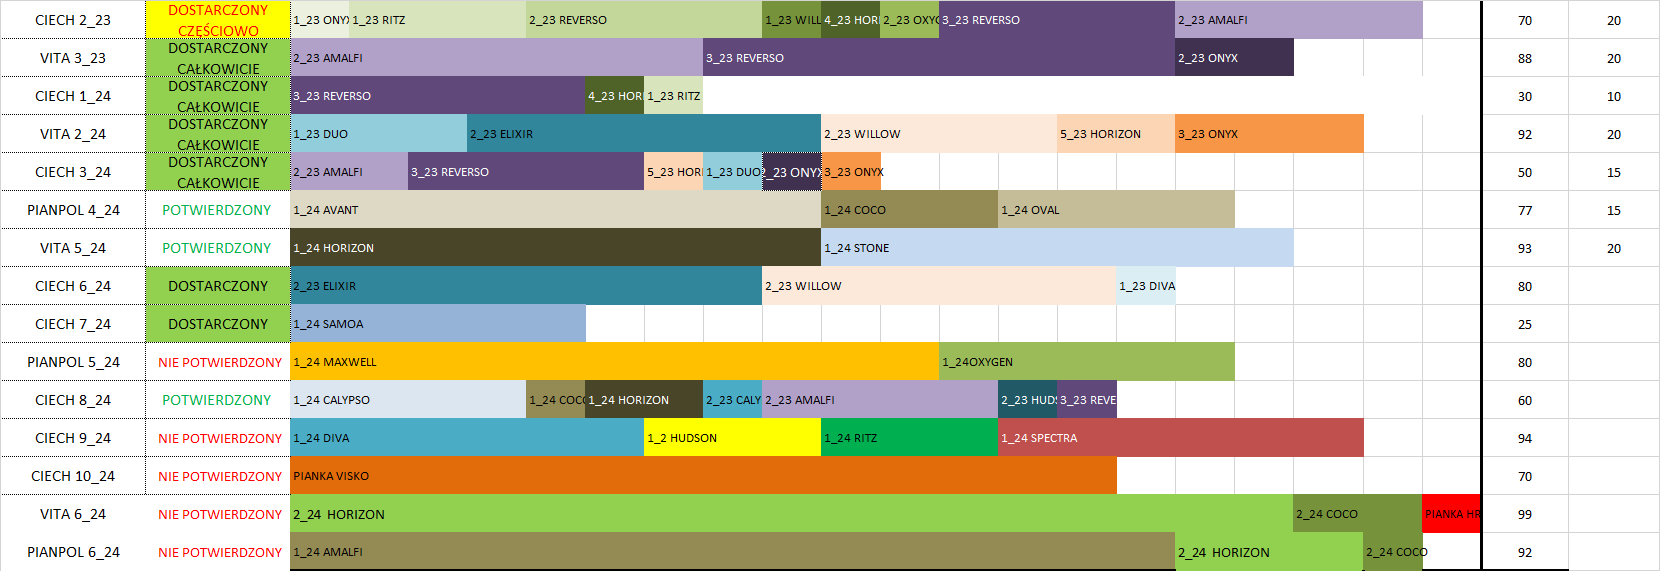

In [ ]:
df = pd.concat([
    obietosci_samochodow("CIECH", zp_tab).groupby(["SAMOCHOD", "KOMPLETACJA"]).sum()[["OBJ","GAL_OBJ","SHR_OBJ","LEN_OBJ"]].reset_index(),
    obietosci_samochodow("VITA", zp_tab).groupby(["SAMOCHOD", "KOMPLETACJA"]).sum()[["OBJ","GAL_OBJ","SHR_OBJ","LEN_OBJ"]].reset_index(),
    obietosci_samochodow("PIANPOL", zp_tab).groupby(["SAMOCHOD", "KOMPLETACJA"]).sum()[["OBJ","GAL_OBJ","SHR_OBJ","LEN_OBJ"]].reset_index()
])

In [ ]:
df.sort_values(by="SAMOCHOD").reset_index(drop=True)

,SAMOCHOD,KOMPLETACJA,OBJ,GAL_OBJ,SHR_OBJ,LEN_OBJ
0,CIECH 2_23,REVERSO 2_23,2.161790,1.171790,0.000000,0.990000
1,CIECH 3_23,AMALFI 2_23,9.750460,0.000000,0.000000,9.750460
2,CIECH 3_24,DUO 1_23,0.978900,0.000000,0.000000,0.978900
3,CIECH 3_24,HORIZON 5_23,2.040000,0.000000,0.000000,2.040000
4,CIECH 3_24,ONYX 2_23,4.265600,0.000000,0.000000,4.265600
5,CIECH 3_24,REVERSO 3_23,0.467820,0.467820,0.000000,0.000000
6,CIECH 6_24,DIVA 1_23,2.483360,1.044480,1.015680,0.423200
7,CIECH 6_24,ELIXIR 2_23,41.113120,26.218720,0.000000,14.894400
8,CIECH 6_24,WILLOW 2_23,27.599290,15.315765,0.000000,12.283525
9,CIECH 8_24,HORIZON 1_24,10.160750,0.000000,0.000000,10.160750
